In [1]:
import sys
print(sys.version)
print(*sys.path, sep='\n')

3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload

/home/lukec/venv/lib/python3.6/site-packages
/home/lukec/Downloads/jax/build
/home/lukec/.local/lib/python3.6/site-packages
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/home/lukec/venv/lib/python3.6/site-packages/IPython/extensions
/home/lukec/.ipython


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision as tv

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

num_workers = os.cpu_count()
print(num_workers)

cuda:0
6


In [16]:
# parameters for trained CNN
ROOT = os.path.join('.', 'dataset_root')
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
EPOCHS = 30
MODEL_PATH = 'mnist_model3.pt'
CHANNEL = 3

In [17]:
def imshow(tensor_grid, mean=0., std=1., title=None):
    assert isinstance(tensor_grid, torch.Tensor)
    assert len(tensor_grid.size()) == 4, \
        f'For a batch of images only, {tensor_grid.size()} '
    
    tensor_grid = tv.utils.make_grid(tensor_grid)
    grid = tensor_grid.numpy().transpose((1,2,0))
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    
    if title is not None:
        plt.title(title)
        
    plt.pause(0.001)

In [18]:
# prepare data
# mean, std = [0.49139947 0.48215836 0.44653094], [0.20230092 0.1994128  0.20096162]
transform = tv.transforms.Compose([
        tv.transforms.ToTensor(),
#         tv.transforms.Normalize(mean, std)
])

train_data = tv.datasets.CIFAR10(
    ROOT,
    train=True,
    download=True,
    transform=tv.transforms.Compose([
        tv.transforms.ToTensor(),
#         tv.transforms.Normalize(mean, std)
    ]))
train_loader = DataLoader(
    train_data,
    BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers)

test_data = tv.datasets.CIFAR10(
    ROOT,
    train=False,
    download=True,
    transform=tv.transforms.Compose([
        tv.transforms.ToTensor(),
#         tv.transforms.Normalize(mean, std)
    ]))
test_loader = DataLoader(
    test_data,
    BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers)

n_train = len(train_loader.dataset)
n_test = len(test_loader.dataset)
print(f'Train = {n_train}, Test = {n_test}')

classes = np.array(['plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'])
print(f'Classes = {len(classes)}')

Files already downloaded and verified
Files already downloaded and verified
Train = 50000, Test = 10000
Classes = 10


In [30]:
images = next(iter(train_loader))[0]
b, c, h, w = images.size()
print(images.size())
print(f'Pixel count = {c * h * w}')

x = torch.rand(1, c, h, w)

conv = nn.Conv2d(3, 64, 3, 1)
x = conv(x)
print(x.size())
conv = nn.Conv2d(64, 64, 3, 1)
x = conv(x)
print(x.size())
pool = nn.MaxPool2d(2)
x = pool(x)
print(x.size())
conv = nn.Conv2d(64, 128, 3, 1)
x = conv(x)
print(x.size())
conv = nn.Conv2d(128, 128, 3, 1)
x = conv(x)
print(x.size())
pool = nn.MaxPool2d(2)
x = pool(x)
print(x.size())
conv = nn.Conv2d(128, 256, 3, 1)
x = conv(x)
print(x.size())
conv = nn.Conv2d(256, 384, 3, 2)
x = conv(x)
print(x.size())

print('\nDecoding')
convt = nn.ConvTranspose2d(384, 256, 3, 2)
x = convt(x)
print(x.size())
convt = nn.ConvTranspose2d(256, 128, 3, 1)
x = convt(x)
print(x.size())
up = nn.Upsample((10, 10), mode='bilinear', align_corners=True)
x = up(x)
print(x.size())
convt = nn.ConvTranspose2d(128, 128, 3, 1)
x = convt(x)
print(x.size())
convt = nn.ConvTranspose2d(128, 64, 3, 1)
x = convt(x)
print(x.size())
up = nn.Upsample((28, 28), mode='bilinear', align_corners=True)
x = up(x)
print(x.size())
convt = nn.ConvTranspose2d(64, 64, 3, 1)
x = convt(x)
print(x.size())
convt = nn.ConvTranspose2d(64, 3, 3, 1)
x = convt(x)
print(x.size())

torch.Size([32, 3, 32, 32])
Pixel count = 3072
torch.Size([1, 64, 30, 30])
torch.Size([1, 64, 28, 28])
torch.Size([1, 64, 14, 14])
torch.Size([1, 128, 12, 12])
torch.Size([1, 128, 10, 10])
torch.Size([1, 128, 5, 5])
torch.Size([1, 256, 3, 3])
torch.Size([1, 384, 1, 1])

Decoding
torch.Size([1, 256, 3, 3])
torch.Size([1, 128, 5, 5])
torch.Size([1, 128, 10, 10])
torch.Size([1, 128, 12, 12])
torch.Size([1, 64, 14, 14])
torch.Size([1, 64, 28, 28])
torch.Size([1, 64, 30, 30])
torch.Size([1, 3, 32, 32])


In [34]:
class Autoencoder(nn.Module):
    def __init__(self, batch_size=BATCH_SIZE, c=CHANNEL):
        super(Autoencoder, self).__init__()
        self.batch_size = batch_size
        self.c = c
        
        self.encoder = nn.Sequential(
            nn.Conv2d(c, 64, 3, 1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, 1),
            nn.ReLU(),
            nn.Conv2d(256, 384, 3, 2))
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(384, 256, 3, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, 1),
            nn.ReLU(),
            nn.Upsample((10, 10), mode='bilinear', align_corners=True),
            nn.ConvTranspose2d(128, 128, 3, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, 1),
            nn.ReLU(),
            nn.Upsample((28, 28), mode='bilinear', align_corners=True),
            nn.ConvTranspose2d(64, 64, 3, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 3, 1),
            nn.Tanh())
                
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        assert isinstance(x, torch.Tensor) \
            and x.size() == (self.batch_size, c, 32, 32)
        
        return self.encoder(x)
    
    def decode(self, x):
        assert isinstance(x, torch.Tensor) \
            and x.size() in ((self.batch_size, 384, 1, 1), (self.batch_size, 384))
        
        if x.size() == (self.batch_size, 384):
            x = x.view(self.batch_size, 384, 1, 1)
        
        return self.decoder(x)

In [35]:
autoencoder = Autoencoder()
autoencoder.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 384, kernel_size=(3, 3), stride=(2, 2))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(384, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Upsample(size=(10, 10), mode=bilinear)
    (5): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): ConvTra

torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 384, 1, 1])


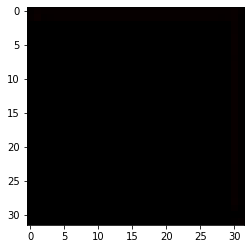

In [36]:
# sanity check
# x are noise images
x = torch.rand(b, c, h, w)
print(x.size())
x = x.to(device)

output = autoencoder(x)
print(output.size())
assert output.size() == x.size()

en = autoencoder.encode(x)
print(en.size())
assert en.size() == (BATCH_SIZE, 384, 1, 1)

de = autoencoder.decode(en)
assert de.size() == x.size()

# y are encoded images
y = torch.randn(BATCH_SIZE, 384)
y = y.to(device)
de = autoencoder.decode(y)
assert de.size() == x.size()

plt.figure()
imshow(output[:1].cpu().detach())
plt.show()

In [37]:
optimizer = torch.optim.Adam(
    autoencoder.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY)

In [38]:
def train(autoencoder, loader, optimizer, epochs=EPOCHS):
    autoencoder.train()
    
    for epoch in range(epochs):
        total_loss = 0.0
        since = time.time()
        
        for x, y in loader:
            x = x.to(device)
            batch_size = x.size(0)

            optimizer.zero_grad()
            outputs = autoencoder(x)
            loss = F.mse_loss(outputs, x)
            loss.backward()    
            optimizer.step()
            
            total_loss += loss.item() * batch_size
        
        time_elapsed = time.time() - since
        total_loss = total_loss / len(loader.dataset)
        print('Epoch: {:2d} - Time: {:.0f}m {:.1f}s - Loss: {:.4f}'.format(
            epoch + 1,
            time_elapsed // 60, time_elapsed % 60,
            total_loss))

In [39]:
since = time.time()

train(autoencoder, train_loader, optimizer)

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.1f}s'.format(
    time_elapsed // 60,
    time_elapsed % 60))

Epoch:  1 - Time: 0m 16.7s - Loss: 0.0250
Epoch:  2 - Time: 0m 16.9s - Loss: 0.0136
Epoch:  3 - Time: 0m 17.0s - Loss: 0.0116
Epoch:  4 - Time: 0m 16.9s - Loss: 0.0105
Epoch:  5 - Time: 0m 17.5s - Loss: 0.0096
Epoch:  6 - Time: 0m 16.6s - Loss: 0.0089
Epoch:  7 - Time: 0m 16.6s - Loss: 0.0084
Epoch:  8 - Time: 0m 16.4s - Loss: 0.0081
Epoch:  9 - Time: 0m 16.4s - Loss: 0.0079
Epoch: 10 - Time: 0m 16.4s - Loss: 0.0076
Epoch: 11 - Time: 0m 16.4s - Loss: 0.0075
Epoch: 12 - Time: 0m 16.4s - Loss: 0.0073
Epoch: 13 - Time: 0m 16.4s - Loss: 0.0071
Epoch: 14 - Time: 0m 16.4s - Loss: 0.0070
Epoch: 15 - Time: 0m 16.4s - Loss: 0.0070
Epoch: 16 - Time: 0m 16.4s - Loss: 0.0069
Epoch: 17 - Time: 0m 16.4s - Loss: 0.0068
Epoch: 18 - Time: 0m 16.4s - Loss: 0.0067
Epoch: 19 - Time: 0m 16.4s - Loss: 0.0068
Epoch: 20 - Time: 0m 16.4s - Loss: 0.0065
Epoch: 21 - Time: 0m 16.4s - Loss: 0.0065
Epoch: 22 - Time: 0m 16.5s - Loss: 0.0064
Epoch: 23 - Time: 0m 17.3s - Loss: 0.0064
Epoch: 24 - Time: 0m 16.9s - Loss:

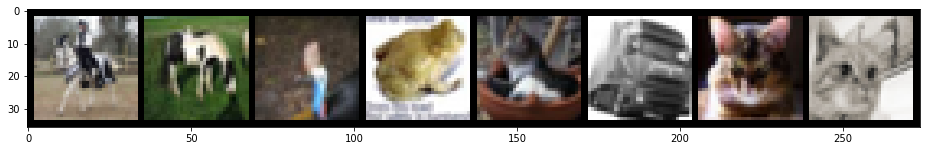

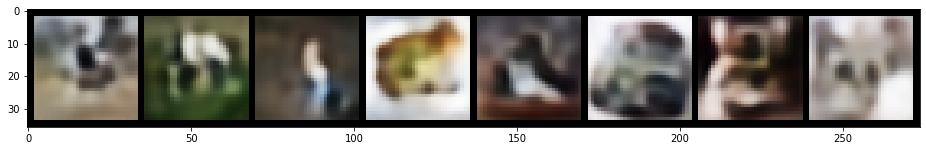

In [40]:
inputs = next(iter(test_loader))[0]
inputs = inputs[:8].to(device)
outpus = autoencoder(inputs)

plt.figure(figsize=[16, 8])
imshow(inputs.cpu().detach())
plt.show()

plt.figure(figsize=[16, 8])
imshow(outpus.cpu().detach())
plt.show()

In [41]:
torch.save(autoencoder.state_dict(), 'cifar_autoencoder.pt')